In [13]:
# Notebook 4: Model Training
import torch
import numpy as np
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, classification_report

# Use best available hardware for training
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Training on: {device}")

# Dataset class (same as model setup)
class MusicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        tokens = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )
        
        return {
            'input_ids': tokens['input_ids'].flatten(),
            'attention_mask': tokens['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load data
split_data = np.load('train_val_split.npy', allow_pickle=True).item()
X_train = split_data['X_train']
X_val = split_data['X_val']
y_train = split_data['y_train']
y_val = split_data['y_val']

label_classes = np.load('label_classes.npy', allow_pickle=True)
tokenizer = AutoTokenizer.from_pretrained('./tokenizer')

# Load XLM-RoBERTa model for training
model = AutoModelForSequenceClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=len(label_classes)
)
model = model.to(device)

# Create datasets
train_dataset = MusicDataset(X_train, y_train, tokenizer)
val_dataset = MusicDataset(X_val, y_val, tokenizer)

print(f"Training on {len(train_dataset)} samples")
print(f"Validating on {len(val_dataset)} samples")

# Training configuration
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=20,
    learning_rate=2e-5,  # Good for XLM-RoBERTa
    weight_decay=0.01,
    warmup_steps=50,
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
)

# Define metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("Starting training...")
trainer.train()

# Evaluate model
print("Evaluating model...")
eval_results = trainer.evaluate()
print(f"Final accuracy: {eval_results['eval_accuracy']:.3f}")

# Detailed results
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=label_classes))

# Save model
trainer.save_model('./final_model')
tokenizer.save_pretrained('./final_model')
print("Model saved!")
print("Training complete!")

Training on: mps


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on 160 samples
Validating on 40 samples
Starting training...


/var/folders/gc/twz74xw16ss5nsq90k3zs56c0000gn/T/ipykernel_44881/17069208.py:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/homebrew/Caskroom/miniforge/base/envs/testEnv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.778100,1.772830,0.200000
2,1.746900,1.765138,0.200000
3,1.712900,1.458782,0.675000
4,1.255100,0.873223,0.800000
5,0.932100,0.638964,0.900000
6,0.647200,0.551386,0.925000


/opt/homebrew/Caskroom/miniforge/base/envs/testEnv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniforge/base/envs/testEnv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniforge/base/envs/testEnv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniforge/base/envs/testEnv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pin

Evaluating model...


/opt/homebrew/Caskroom/miniforge/base/envs/testEnv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Final accuracy: 0.925


/opt/homebrew/Caskroom/miniforge/base/envs/testEnv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Classification Report:
                            precision    recall  f1-score   support

   Experimental & Abstract       1.00      1.00      1.00         7
       Identity & Heritage       0.86      1.00      0.92         6
Introspection & Philosophy       1.00      0.88      0.93         8
      Love & Relationships       0.80      1.00      0.89         8
         Place & Landscape       1.00      0.50      0.67         4
         Social Commentary       1.00      1.00      1.00         7

                  accuracy                           0.93        40
                 macro avg       0.94      0.90      0.90        40
              weighted avg       0.94      0.93      0.92        40

Model saved!
Training complete!


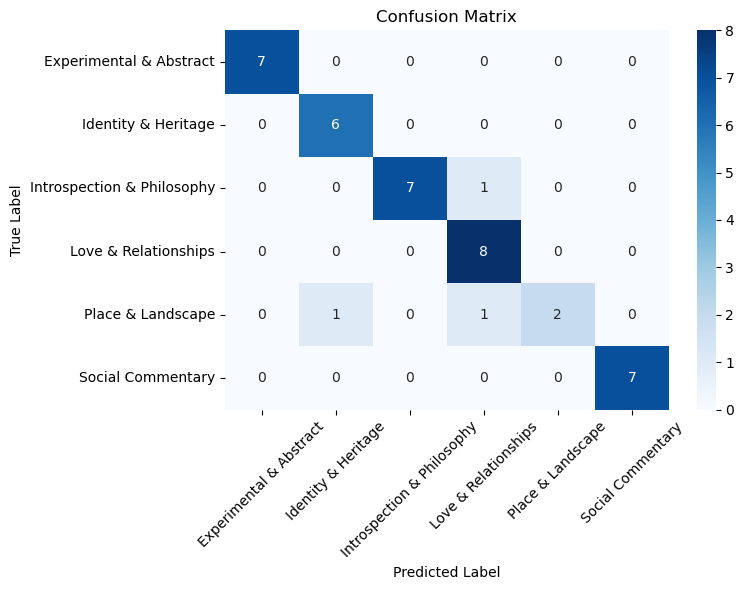

Per-class accuracy:
Experimental & Abstract: 1.000 (7/7)
Identity & Heritage: 1.000 (6/6)
Introspection & Philosophy: 0.875 (7/8)
Love & Relationships: 1.000 (8/8)
Place & Landscape: 0.500 (2/4)
Social Commentary: 1.000 (7/7)


In [15]:
# Confusion matrix and analysis
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_classes, yticklabels=label_classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Per-class accuracy
print("Per-class accuracy:")
for i, theme in enumerate(label_classes):
    correct = sum(1 for true, pred in zip(y_val, y_pred) if true == i and pred == i)
    total = sum(1 for true in y_val if true == i)
    if total > 0:
        accuracy = correct / total
        print(f"{theme}: {accuracy:.3f} ({correct}/{total})")
    else:
        print(f"{theme}: No samples")